# 2C - Language Model Surprisal and EEG Data
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/annabavaresco/ancm2025/blob/main/docs/week_2/2C_LM_Surprisal_and_EEG_data.ipynb)
[![View filled in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annabavaresco/ancm2025/blob/main/docs/week_2/2C_LM_Surprisal_and_EEG_data.ipynb)

_by Jelle Zuidema (September 2022), with edits by Anna Bavaresco (July 2024)_

---
This notebook is based on Rasyan Ahmed's master thesis code.

Today we'll be working on the EEG data collected by _[Broderick et al., 2018](https://www.sciencedirect.com/science/article/pii/S0960982218301465)_ while participants were listening to an audiobook. The authors were interested in the N400 component of event-related potentials.

What's special about N400? It has consistently been shown to signal _surprisal_, which can roughly be defined as 'incongruence with the surrounding context'. To illustrate, if we read a sentence broccoli with a word that is completely out of context -- and therefore _surprising_ -- our brains will signal this with a spike in the N400 component.

Broderick and colleagues, however, move away from this incongrous word paradigm and look at words during natural speech comprehension more in general. In particular, they ivestigate whether N400 is tracking the contextual semantic content of words while they are being processed. How do they do this? They construct word vectors representing how semantically dissimilar a word is to the preceding context, and then regress these vectors against EEG data.

Let's briefly zoom in into how the authors computed these 'dissimilarity vectors'. Let's consider the sentence "Mary saw the dog as she walked past the garden" (this is a made-up example for illustration purposes). If we want to compute the dissimilarity vector for a word -- let's say 'dog' -- as the authors did, we should first compute word embeddings for all the words in the sentence using word2vec and then do the following:
1. Select the word embedding corresponding to 'dog'
2. Compute the average of the word embeddings from all the words preceding 'dog' (so here 'Mary', 'saw', 'the')
3. Compute the Pearson correlation between the 'dog' vector and the average vector (form point 2)
4. Subtract the correlation from 1 (because we're trying to compute _dissimilarity_ and not _similarity_)

This semantic dissimilarity measure can be considered as a 'representation of the meaning added to a sentence by that word'.

We'll look at how these vectors are used to learn us something about EEG responses later on in this notebook. For now, let's focus on _semantic dissimilarity_ and how it was operationalised by Broderick and colleagues.

###**QUESTION 1**
Are there are any shortcomings with using word2vec vectors? Do you think that the contextualised vectors that we can get from more recent language models might be more suitable for the purpose? (⚠️_Spoiler alert:_ all these rhetorical questions seem to presuppose a 'yes')

## Importing libraries and downloading data

Here we're simply importing some libraries and downloading the `.zip` files with the data that we're going to use in this lab. Just run the cells below for now, you'll find out what you have downloaded in the next sections.

In [ ]:
%%capture
! pip install mne
! pip install -q scipy

In [ ]:
import scipy.io as sio
import numpy as np
import mne
from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from os.path import join

We are going to be working with the following files in this lab. In order to access them, click on the links below and then hit the "add shortcut to Google Drive" button.
- [Subject19.zip](https://drive.google.com/file/d/1ZWopKDEf1FPDciVPATcUrAkF8XY0WgK6/view?usp=sharing)
- [Stimuli.zip](https://drive.google.com/file/d/1c04Z8YNUjoRkGfNu2zGQDM6gFpRs-Cab/view?usp=sharing)
- [vectors.zip](https://drive.google.com/file/d/1yF3PK94RFRxZyMuQHHOk8iS7yZMMJ15j/view?usp=sharing)
- [results.zip](https://drive.google.com/file/d/1lXNhl3WUK48Juj0oA-itR_tkONdlK2G4/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's now unzip the files. You will need to update the following paths based on where the files are located in your Drive.

In [ ]:
!unzip -qq '/content/drive/MyDrive/PhD/ANCM/Lab Materials 2024/Subject19.zip'
!unzip -qq '/content/drive/MyDrive/PhD/ANCM/Lab Materials 2024/Stimuli.zip'
!unzip -qq '/content/drive/MyDrive/PhD/ANCM/Lab Materials 2024/vectors.zip'
!unzip -qq '/content/drive/MyDrive/PhD/ANCM/Lab Materials 2024/results.zip'

#Loading and preprocessing the EEG data

The following functions will make sure that the EEG data and the dissimilarity vectors we have unzipped are now properly loaded. More specifically, the functions below allow us to specify a list of participants and the model used to compute the word embeddings. For each participant, the functions will return:
* the 128-channel EEG data (where channels correspond to the number of electrodes placed on subjects' sculps)
* the 2-channel EEG data corresponding to the mastoids
* the dissimilarity vectors

Are you wondering what mastoids are?👀 They are bones that are part of our skulls, located behind our ears. Why do we care about them here? 🤔 They are important for data _re-referencing_. We'll learn more about re-refering later on in the notebook.

   

In [ ]:
#@title Helper functions for loading data

def load_subject_data(subj_id, method, normalised_sim, freq):
  raw = []
  ms = []
  dis_vector = []
        #print('Load eeg & dissimilarity values: subject: ', sub, "/", len(subs), end = "\r", flush=True)

  for run in range(1,21): # for each run
    data = sio.loadmat(f"Subject{subj_id}/Subject{subj_id}_Run{run}.mat" )
    raw_run = data['eegData'].T
    ms_run = data['mastoids'].T
    words = sio.loadmat(f"Stimuli/Text/Run{run}.mat")

    # create list of word similaritys in order and normalise.
    norm_flat_sim = [simz * normalised_sim for sentence in sim[run-1] for simz in sentence]

    if len(norm_flat_sim)!= len(words['onset_time']):
      print(subj_id, run, len(norm_flat_sim), len(words['onset_time']))

            # create empty vector of same size as the eeg
    dis_vector_run = np.zeros((1, raw_run.shape[1]))

    if method == 'random_loc':
      random_locations = random.sample(range(0,raw_run.shape[1]), len(norm_flat_sim))


    # for each word, find its onset, and then place it there in the empty vector.
    for j in range(len(norm_flat_sim)):
      if method == 'random_loc':
        on = random_locations[j]
      else:
        on = int(np.floor(words['onset_time'][j] * freq))

      dis_vector_run[0][on] = (1-norm_flat_sim[j])

    raw.append(raw_run)
    ms.append(ms_run)
    dis_vector.append(dis_vector_run)

  return raw, ms, dis_vector

def load_eeg_and_disimilarlity_vector(sim, method, subjects, freq, norm):

    # flatten the similarity values (from 3D list to 1D list)

    flat_sim = [word for sentence in [sentence for run in sim for sentence in run] for word in sentence]

    # normalize to the values of the broderick similarity values.
    normalised_sim = norm/np.mean(flat_sim)

    #
    raw_subs = []
    ms_subs = []
    dis_vector_subs = []

    for sub in tqdm(subjects):  # for each subject
        raw, ms, dis_vector = load_subject_data(sub, method, normalised_sim, freq)
        raw_subs.append(raw)
        ms_subs.append(ms)
        dis_vector_subs.append(dis_vector)

    print('Data successfully loaded!')
    return(dis_vector_subs, ms_subs, raw_subs)


In [ ]:
vector = 'bert_4_False' # use word likehoods obtained from a Bert model, with access to 4 prior words and no access to future context
norm_val = 0.33820258789060476
subs = [19]
sim = np.load(join('vectors', f"{vector}.npy"), allow_pickle=True)
sfreq = 128
dis_vector, raw_mastoids, raw_eeg = load_eeg_and_disimilarlity_vector(sim, vector, subs, sfreq, norm_val)


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-5-1991b1a14af6>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  on = int(np.floor(words['onset_time'][j] * freq))


Data successfully loaded!


Great, now we have our raw data and distance vectors successfully loaded. Next, we'll do some data preprocessing. We'll be using the [MNE](https://mne.tools/stable/index.html) library for this. The main preprocessing operations which will be performed by the following functions are:
* _re-referencing_: EEG electrodes record voltages that are relative to other voltages (recorded at other electrodes). In this sense, we are lacking a single 'reference' to interpret the voltages measured by the electrodes. This is why we need to do some _re-referencing_ of the EEG data. But what should be our point of reference? A common choice -- which we'll be implementing here -- is to use the mastoids as reference electrodes, because the brain activity they capture is somehow 'weaker' than the brain activity recorded by elsewhere-located electrodes
* _filtering_: we'll be filtering out the signal outside the 1-8Hz bandwidth


Are you curious about the MNE functions used in the following functions? Then check out the [MNE documentation](https://mne.tools/stable/index.html)!

In [ ]:
#@title Helper function for preprocessing

def process_eeg(dis_vector, raw_mastoids, raw_eeg, var_limit):

    raws = np.empty((20,), dtype=object)
    ms = np.empty((20,), dtype=object)
    dv = np.empty((20,), dtype=object)
    filtered = np.empty((20,), dtype=object)
    data = {}
    for i in range(1,21):

        # load data of the prev cell
        raws[i-1] = raw_eeg[i-1].T
        ms[i-1] = raw_mastoids[i-1].T
        dv[i-1] = dis_vector[i-1].T


        # add mastoids as the last two channels.
        raw = np.concatenate((raw_eeg[i-1],raw_mastoids[i-1]))


        montage = mne.channels.make_standard_montage('biosemi128');
        montage.ch_names = montage.ch_names + ['M1', 'M2']
        montage.dig = montage.dig + [montage.dig[4],montage.dig[5]]


        # info = mne.create_info(montage.ch_names[:130], sfreq, 'eeg', montage=montage)
        info = mne.create_info(montage.ch_names[:130], sfreq, 'eeg', verbose=False)
        raw = mne.io.RawArray(raw, info)
        raw.add_channels


        # remove the standard reference mne sets upon it.
        raw, _ = mne.set_eeg_reference(raw, [])

        # reference instead using the average of the last two channels (mastoids)
        raw, _ = mne.set_eeg_reference(raw, montage.ch_names[128:130])

        # bandpass filter the data without the mastoids

        raw = raw.drop_channels(montage.ch_names[128:130])
        raw = raw.filter(1,8)

        test = raw.get_data()

        var = [np.var(channel[1280:-1280]) for channel in test]
        raw.info['bads'] = (np.array(montage.ch_names[:128])[np.array(var[:128])>var_limit]).tolist()

        raw.interpolate_bads()

        filt = raw.get_data()
        filtered[i-1] = filt[:128].T

    data['raw'] = raws
    data['ms'] = ms
    data['dv'] = dv
    data['filtered'] = filtered


    return data


In [ ]:
# remove the capture command if you want the function to print all its very verbose outputs :)
%%capture
data = process_eeg(dis_vector[0], raw_mastoids[0], raw_eeg[0], 100000)

Now that we have loaded and processed the data, it is time to have a look at the original EEG measurements and the effects of preprocessing 👀 The original data is available as `data['raw']`. The filter data can be accessed as `data['filterd']`.


In [ ]:
eeg_before = data['raw']
eeg_after = data['filtered']

Before plotting, let's have a look at the data dimensionality and make sure we know what each dimension corresponds to.

In [ ]:
print(eeg_before.shape)
print(eeg_before[1].shape)

(20,)
(23257, 128)


Here:
* 20 represents the number of trials (segments) that each participant undertook
* 128 is the number of channels (electrodes)
* 2285 are the time points per trial

### **QUESTION 2**

Choose the EEG responses for one trial and plot them for one channel (of your choice) before and after preprocessing. Then describe, in rough outline, what preprocessing has done to the signal.

_Hint_: you might want to focus on a subset of time points to have a "closer look" at the signal

## Training the TRFs (or not)

Now that our data is preprocessed, let's see how we can use it to get a cognitive model. Our goal is to obtain _temporal response functions_ (TRFs)*. TRFs are linear models that describe the relationship between stimuli and responses. In our case, the stimuli are words and the responses are the EEG recordings. Therefore, we are looking for a function that links EEG responses to the presented words -- or better, their _surprisal_.

But how do we get these TRFs? The authors trained some ridge regression models to predict EEG responses based on distance vectors. If you are curious about the specific steps that can be used to train these regression models, you can have a look at the code below, but its detailed understanding is not important for this assignment.

Since training the models can be quite time consuming, we'll skip this step and look at the TRFs by loading some pre-computed coefficients.


---
\*If you find the concept of a TRF a bit hard to grasp, I would recommend looking at [this](https://eelbrain.readthedocs.io/en/stable/auto_examples/temporal-response-functions/trf_intro.html#sphx-glr-auto-examples-temporal-response-functions-trf-intro-py) resource, which has some nice and clear visualisations.


In [ ]:
#@title Helper functions for training the TRF

def TRF(subject_data, start=0, end=1, save=None, shuffle=False, second_folder = 'randoms/'):

    for run in tqdm(range(start,end)):

        #print('run', run)
        scores_subs=[]
        coefs_subs=[]
        error_subs=[]
        for sub in tqdm(subs):

            # run value as random seed. makes reproduction possible if we need extra info later on.
            random.seed(run)
            data = subject_data[subs.index(sub)]
            dv = np.vstack(data['dv'])

            if shuffle:
                # create a list of all disimilarity values.
                ddv = np.array([d for d in dv if d>0])

                # shuffle this list.
                random.shuffle(ddv)

                # for each non 0 in real dissimilarity vector
                i = 0
                for j in range(len(dv)):
                    if dv[j] > 0:

                        # add the i element of the shuffled list of dissimilarity values.
                        dv[j] = ddv[i]
                        i+=1

            Y = np.vstack(data['filterd'])

            # normalisation method. basicly just subtracts the average and devides by the standerd deviations
            scaler = StandardScaler()           # initalise scaler
            scaler.fit(Y)                       # finds the average and sd
            Y = scaler.transform(Y)      # scales each value.


            #Initialize the model
            rf = ReceptiveField(tmin, tmax, sfreq, feature_names=['envelope'],
                                estimator=1., scoring='corrcoef')

            # calculate how many items there are between the delays
            n_delays = int((tmax - tmin) * sfreq) + 2

            # setup 5fold CV
            n_splits = 5
            cv = KFold(n_splits)

            DV = np.array([dv[i-78:i,] for i in range(78,dv.shape[0])])

            # Simple linear regression for each time step using 5fold CV
            coefs = np.zeros((n_splits, n_channels, n_delays))
            scores = np.zeros((n_splits, n_channels))

            err= []
            # Iterate through splits, fit the model, and predict/test on held-out data
            for ii, (train, test) in enumerate(cv.split(dv)):  # split the data 4:1 (train:test) for each different way.
                #print('split %s / %s' % (ii + 1, n_splits))

                rf.fit(dv[train], Y[train])

                scores[ii] = rf.score(dv[test], Y[test])
                # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 feature
                coefs[ii] = rf.coef_[:, 0, :]

                # calculate errors

                W = np.flip(coefs[ii],1) # define Weights as the flipped coefs
                #print(test)

                test=test[test>=78] # remove the first 78 values, as we dont have full data for them
                test=test -78
                #print(test)
                DV2 = DV[test] # select only the dissimilarity values for the test set
                real = Y[test]

                DVs = np.sum(DV2,1)
                mask = [s for s in range(0,len(DV2)) if DVs[s]!=0]
                DV2 = DV2[mask] # remove all test cases with 0 dv values
                real = real[mask]

                pred = np.array([W @ s for s in DV2]).squeeze() # calculate predicted value.

                m = np.mean(real,0)
                SStot = np.sum((real-m)**2,0)
                SSreg = np.sum((pred-m)**2,0)
                SSres = np.sum((real-pred)**2,0)
                r2 = 1-(SSres/SStot)
                errors = np.array([SStot,SSreg,SSres,r2])

                err.append(errors)

            times = rf.delays_ / float(rf.sfreq)

            scores_subs.append(scores)
            coefs_subs.append(coefs)
            error_subs.append(err)

        if shuffle==True and save and ((end-start)>1):
            # save results
            saveFunc(loc, run_string , scores_subs, coefs_subs, error_subs, length)

    return(scores_subs, coefs_subs, error_subs) # save last run results

def train(vector, preprocess = 100000, backup = 'pearson', start=0, end=1, save=True, shuffle=False):

    if vector == 'random_loc':
        similarity_location = vector_loc +  backup + '.npy'
    else:
        similarity_location = vector_loc +  vector + '.npy'

    # loads the similarity values
    sim = np.load(similarity_location, allow_pickle=True)

    dis_vector, raw_mastoids, raw_eeg = load_eeg_and_disimilarlity_vector(sim, vector)
    data = process_eeg(dis_vector, raw_mastoids, raw_eeg, preprocess)

    scores_subs, coefs_subs, error_subs = TRF(data)
    #scores_subs, coefs_subs, error_subs = TRF(data, start=3, end=100, save=save, shuffle=True, second_folder)

    if end-start > 1:
        combine_multi_runs()

    if save:
        if vector == 'pearson':
            run_string = vector + '_' + str(preprocess)

        elif vector[:4] == 'bert':
            run_string = vector + '_' + str(preprocess)

        elif vector == 'static':
            run_string = vector + '_' + str(preprocess)

        elif vector == 'random_loc':
            run_string = vector + '(' + backup + ")" + '_' + str(preprocess)

        elif shuffle:
            run_string = 'shuffle(' + vector + ')' + '_' + str(preprocess)

        saveFunc(results_folder, run_string, scores_subs, coefs_subs, error_subs, end-start)

    return(scores_subs, coefs_subs, error_subs)

#scores_subz, coefs_subz, error_subz = train(vector_loc, method,  999999999999999999)


## Plotting the obtained TRF coefficients

Now we'll be having a look at some plots which will help us understand which TRFs have been learned by the models.

In [ ]:
#@title Helper function for plotting

def plot_curve(ch, sd, ax, title, plot_data, multi_coefs_avg, multi_coefs_std):
    i = 0
    j = 0
    for tup in plot_data:
        if tup[3] == "single":
            ax.plot(times,coefs[i][ch], label= tup[1])
            i+=1

        elif tup[3] == "multi":
            ax.plot(times, multi_coefs_avg[j][ch], label = tup[1] + " mean")
            ax.fill_between(times,multi_coefs_avg[j][ch]-multi_coefs_std[j][ch]*sd, multi_coefs_avg[j][ch]+multi_coefs_std[j][ch]*sd, alpha=0.2, label =tup[1] + " "+ str(sd) + "sd")
            j+=0
    ax.axhline(0, ls='--', color='black')
    #ax.set_ylim(-0.09 ,0.05)
    ax.set(title=title)

The next two cells will simply set some parameters and import the right coefficients. More specifically, we'll be importing coefficients for the original Broderick models (based on dissimilarity vectors, as explained at the beginning of the notebook) and for a model computed from BERT-derived word embeddings.

In [ ]:
# select data to load
sub = np.array([19])
sun = [1]
plot_data = []

results_folder = 'results/'

# start/ end time of relevant time period of word onset.
tmin = 0
tmax = 0.6

# Broderick
plot_data.append(("pearson_100000.npy",'Broderick (1-8Hz)',"b", "single"))

# static
#plot_data.append(("static_100000.npy","static","brown", "single"))

# bert_4_false
plot_data.append(("bert_4_False_100000.npy","BERT4", "red", "single"))

In [ ]:
coefs = []
scores = []

for tup in plot_data:

    if tup[3] == "single":
        # load the data of the subjects you want to include + square scores to get r2
        coef = np.load(f'{results_folder}coefs/{tup[0]}')[sub-1]
        score = np.load(f'{results_folder}scores/{tup[0]}')[sub-1]**2
        score = np.nan_to_num(score)

        # mean out the subject axis
        coef = coef.mean(axis=0)
        score = score.mean(axis=0)

        # mean out the cross validation axis
        coef = coef.mean(axis=0)
        score = score.mean(axis=0)

        coefs.append(coef)
        scores.append(score)

n_channels = coefs[0].shape[0]
n_points =  coefs[0].shape[1]

# define a n_points long array that defines what time a coefficent belongs to.
# used as the x axis in plotmtrfs.
times = np.array(range(0,n_points))/ 128

montage =  mne.channels.make_standard_montage('biosemi128')
info = mne.create_info(montage.ch_names[:n_channels], n_channels, 'eeg')

Now we'll indeed be plotting the TRFs for the two different models of word surprisal.

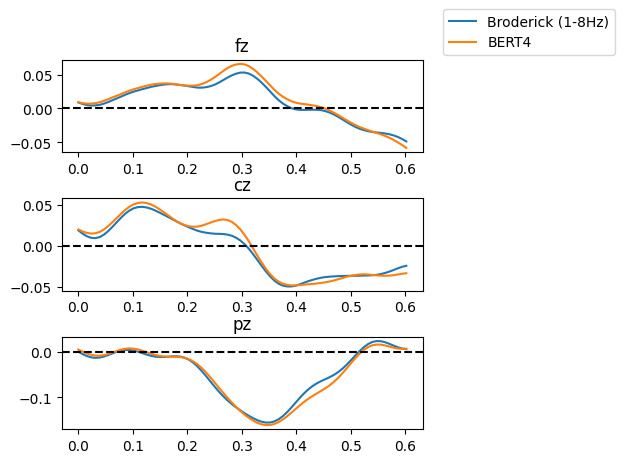

In [ ]:
sd = 1.6
pl =1
nrow = 3
ncol = 2
widths = [0,3,0.1,0.1]
heights = [0,33,0.33,0.33]
# gr = grid.GridSpec(wspace= , hspace= width_ratios= , height_ratios= )
gri = {'wspace':0.5,'hspace':0.5,'width_ratios':[1,0.1]}
fig, axes = plt.subplots(nrow,ncol, squeeze = False, gridspec_kw = gri)

plot_curve(84,sd,axes[0,0],'fz', plot_data, coefs, scores)
plot_curve(0,sd,axes[1,0],'cz', plot_data, coefs, scores)
plot_curve(20,sd,axes[2,0],'pz', plot_data, coefs, scores)
axes[0,1].axis("off")
axes[1,1].axis("off")
axes[2,1].axis("off")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
fig.show();


Are you wondering what 'fz', 'cz' and 'pz' mean? They are standard ways of referring to EEG electrodes. The first letter refers to the brain lobe where the electrode is positioned (F for _frontal_, C for _central_, P for _parietal_). The second letter Z stands for 'zero' and indicates that the electrodes are placed on the midline sagittal plane of the skull. But why are we only looking at the Z-positioned electrodes and not at the other ones? The Z electrodes are often used as a point of reference.

### **QUESTION 3**

a) Study the temporal response functions you've just plotted for Broderick's model of word surprisal versus the BERT-based model (with 4 words prior context). Do you observe the N400 component (negative polarization approximately 400 ms after word onset) in some of the channels? Do you observe this polarisation for the same channels across models? Do you find differences between the two models?

b ) Now consider the results you get with a model that simply assigns uniform surprisal values to all words (i.e., it does not distinguish between suprising or unsurpring words). You can find the data for this model in the `static_100000.npy` file. Does that model change your assessment of the performance of the Broderick and BERT models?


Please write down your answers to all the questions in this assignment in a dedicated PDF. There is no page/word limit, but you are encouraged to keep your answers clear and concise. 

